# Exploratory analysis of gcell data

## Load data

In [1]:
import scipy
import pandas as pd
import statsmodels

from google.colab import drive
drive.mount('/content/drive')

!ls /content/drive/MyDrive/2025\ qwc-pqic-gic/Auditory\ cortex\ data/*/*.mat -Slh

# number of neurons per recording
import glob
import gc
for mat in glob.glob('/content/drive/MyDrive/2025 qwc-pqic-gic/Auditory cortex data/*/*.mat'):
    record = scipy.io.loadmat(mat)
    print(mat,':',sum(len(record['allxc'][plane][0]) for plane in range(1,6)))
    del record
    gc.collect()

In [2]:
# load the smallest file
record = scipy.io.loadmat('/home/brainstorm/Downloads/Auditory_cortex_data/Auditory cortex data/081920_355r/allPlanesVariables27-Feb-2021.mat')
# record = scipy.io.loadmat('/content/drive/MyDrive/2025 qwc-pqic-gic/Auditory cortex data/081920_355r/allPlanesVariables27-Feb-2021.mat')

In [3]:
record.keys()

dict_keys(['__header__', '__version__', '__globals__', 'BFinfo', 'CellInfo', 'CorrInfo', 'allZCorrInfo', 'allxc', 'allyc', 'allzc', 'exptVars', 'selectZCorrInfo', 'stimInfo', 'zDFF', 'zStuff', '__function_workspace__'])

# Confirm classical correlation

In [4]:
tuning_curves = pd.concat(
    [
        pd.DataFrame(record['zStuff'][0][plane][0])
        for plane in range(1,6)
    ]
).reset_index().drop(columns='index')

In [5]:
tuning_curves

,0,1,2,3,4,5,6,7,8
0,12.390694,15.736114,26.850230,26.273641,15.061115,12.157273,17.197759,19.777569,26.673842
1,14.710437,12.390372,12.333933,12.110193,12.375612,8.568789,16.017357,17.192882,12.625920
2,18.899687,13.166651,15.916866,19.059703,12.303493,16.367925,16.616543,17.654142,18.782494
3,16.403450,13.218894,13.615465,17.592090,15.361770,15.656932,17.266245,16.762045,21.112917
4,15.962315,11.367415,13.885502,15.681253,11.645656,11.036421,13.117399,10.679451,12.062431
...,...,...,...,...,...,...,...,...,...
454,10.572497,15.747195,12.942996,10.953684,13.755904,11.796201,14.267954,15.842001,11.808158
455,14.089879,14.911311,15.780570,11.877137,14.711298,10.053278,18.880840,13.376637,13.894984
456,11.015321,9.648918,11.791652,11.905616,10.128393,10.071100,13.271535,11.743713,13.601738
457,16.338816,15.665695,14.300783,19.106040,19.432592,19.294137,18.348341,17.695766,12.366102


In [6]:
# SAVE THIS TABLE
corrs = tuning_curves.T.corr()

# confirmed that this is the same matrix as computing classical correlation directly
pd.DataFrame(record['CorrInfo']['SigCorrs'][0][1])

In [7]:
# recalculate classical correlations differently, 0 documentation on how the planes are ordered.

# Select significant / nonsignificant neurons

Nonsignificant = no significant response to any tone
Significant = everything else

In [8]:
import numpy as np

In [9]:
pstim = pd.DataFrame(record['zStuff']['pStim'][0][1])
sigstim = pd.DataFrame(record['CellInfo']['sigStim'][0][1])

In [10]:
# make p-value formats match
pstim_is_sig = pstim.replace(np.nan, 1).map(lambda x: 1 if x < 0.05 else 0)  # not sure how this pvalue is obtained

In [11]:
# All true?
(sigstim == pstim_is_sig).all().all()

np.True_

In [12]:
# 4 graphs - significant <-> significant, sig <-> ns, ns <-> ns, all-to-all

In [13]:
# signals for all planes together
pstim = pd.concat(
    [
        pd.DataFrame(record['zStuff']['pStim'][0][plane])
        for plane in range(1,6)
    ]
).reset_index().drop(columns='index')
pstim_is_sig = pstim.replace(np.nan, 1).map(lambda x: 1 if x < 0.05 else 0)  # what p-value threshold should we use?
pstim_total_sig = pstim_is_sig.T.sum().T
neurons_sig, neurons_notsig = pstim_total_sig[pstim_total_sig > 0].index, pstim_total_sig[pstim_total_sig == 0].index
neurons_sig, neurons_notsig
# SAVE THESE VALUES

(Index([  0,   8,   9,  12,  13,  17,  18,  19,  21,  23,
        ...
        436, 437, 439, 441, 442, 443, 449, 451, 453, 455],
       dtype='int64', length=178),
 Index([  1,   2,   3,   4,   5,   6,   7,  10,  11,  14,
        ...
        445, 446, 447, 448, 450, 452, 454, 456, 457, 458],
       dtype='int64', length=281))

In [14]:
# number of circuit executions
def n_pairs(x):
    assert type(x) is int
    return x*(x-1)//2

print('among all neurons:', n_pairs(len(pstim)))
print('among significant neurons:', n_pairs(len(neurons_sig)))
print('among non-significant neurons:', n_pairs(len(neurons_notsig)))
print('among sig<->nonsig neurons:', len(neurons_notsig) * len(neurons_sig) // 2)

# n_sig * (n_sig-1) / 2 , n_notsig * (n_notsig-1) / 2
# n_sig * (n_sig-1) / 2 + n_notsig * (n_notsig-1) / 2

among all neurons: 105111
among significant neurons: 15753
among non-significant neurons: 39340
among sig<->nonsig neurons: 25009


# coordinates

In [15]:
xs = pd.concat([pd.DataFrame(record['allxc'][plane][0]) for plane in range(1,6)]).rename(columns={0: 'x'}).reset_index().drop(columns='index')
ys = pd.concat([pd.DataFrame(record['allyc'][plane][0]) for plane in range(1,6)]).rename(columns={0: 'y'}).reset_index().drop(columns='index')
zs = pd.concat([pd.DataFrame(record['allzc'][plane][0]) for plane in range(1,6)]).rename(columns={0: 'z'}).reset_index().drop(columns='index')
coords = pd.concat([xs, ys, zs], axis=1)
coords
# SAVE THIS

,x,y,z
0,40.333268,243.282707,-86.518810
1,51.273183,274.138879,-85.027295
2,49.309609,287.042368,-84.362500
3,52.675736,298.543305,-83.744237
4,30.515395,309.483221,-83.129575
...,...,...,...
454,12.282203,222.805429,-11.616340
455,17.050884,232.623302,-11.076617
456,10.038117,262.637942,-9.573719
457,68.664844,218.878280,-11.771708


# Tree pruning

In [16]:
import bct

In [17]:
thr_07 = bct.threshold_absolute(corrs.to_numpy(), 0.7)
thr_08 = bct.threshold_absolute(corrs.to_numpy(), 0.8)
thr_09 = bct.threshold_absolute(corrs.to_numpy(), 0.9)

In [18]:
type(coords)

pandas.core.frame.DataFrame

# Rentian scaling

In [19]:
from scipy import stats
import statsmodels.api as sm


In [20]:
# this is an updated version from bctpy
def my_rentian_scaling(A, xyz, n, seed=42):
    rng = np.random.default_rng(seed)
    m = np.size(xyz, axis=0)  # find number of nodes in system

    # rescale coordinates so they are all greater than unity
    xyzn = xyz - np.tile(np.min(xyz, axis=0) - 1, (m, 1))

    # find the absolute minimum and maximum over all directions
    nmax = np.max(xyzn)
    nmin = np.min(xyzn)

    count = 0
    N = np.zeros((n,))
    E = np.zeros((n,))

    # create partitions and count the number of nodes inside the partition (n)
    # and the number of edges traversing the boundary of the partition (e)
    while count < n:
        # define cube endpoints
        randx = np.sort((nmax - nmin) * rng.random((2,)))
        randy = np.sort((nmax - nmin) * rng.random((2,)))
        randz = np.sort((nmax - nmin) * rng.random((2,)))
    
        # ensure cube is within network boundaries
        randx[0] = max(randx[0], nmin)
        randx[1] = min(randx[1], nmax)
        randy[0] = max(randy[0], nmin)
        randy[1] = min(randy[1], nmax)
        randz[0] = max(randz[0], nmin)
        randz[1] = min(randz[1], nmax)

        # find nodes in cube
        l1 = xyzn[:, 0] > randx[0]
        l2 = xyzn[:, 0] < randx[1]
        l3 = xyzn[:, 1] > randx[0]
        l4 = xyzn[:, 1] < randx[1]
        l5 = xyzn[:, 2] > randx[0]
        l6 = xyzn[:, 2] < randx[1]

        L, = np.where((l1 & l2 & l3 & l4 & l5 & l6).flatten())
        if np.size(L):
            # count edges crossing at the boundary of the cube
            E[count] = np.sum(A[np.ix_(L, np.setdiff1d(range(m), L))])
            # count nodes inside of the cube
            N[count] = np.size(L)
            count += 1

    return N, E

In [21]:
def rent_exp_linreg(A, coords, M=20):
    # M = 1000  # number of partitions, if we have at least M more than neurons, then each partition has about 1 neuron

    N, E = my_rentian_scaling(A, coords.to_numpy(), M, seed=42)
    # bctpy docs say recommended step is to prune partitions with N < M/2, but according to matlab function header, setting random boxes
    N_prime = N # [N < M/2]
    E_prime = E # [N < M/2]

    # Log-log transformation
    log_N_prime = np.log10(N_prime)
    log_E_prime = np.log10(E_prime)
    
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x=log_N_prime, y=log_E_prime)
    
    # The Rent's exponent is the slope
    rent_exponent = slope
    print("Rent's exponent:", rent_exponent)
    
    # Standard error of the estimation
    std_error = std_err
    print("Standard error of the estimation:", std_error)
    return rent_exponent, std_error

In [22]:
def rent_exp_sm(A, coords, M=20):
    # M = 1000  # number of partitions, if we have at least M more than neurons, then each partition has about 1 neuron

    N, E = my_rentian_scaling(A, coords.to_numpy(), M, seed=42)
    # recommended step is to prune partitions with N < M/2
    N_prime = N # [N < M/2]
    E_prime = E # [N < M/2]

    # Log-log transformation
    log_N_prime = np.log10(N_prime)
    log_E_prime = np.log10(E_prime)
    
    # Add a constant (intercept) to the independent value
    log_N_prime = sm.add_constant(log_N_prime)
    
    # Fit the robust linear model
    model = sm.RLM(log_E_prime, log_N_prime, M=statsmodels.robust.norms.TukeyBiweight()) # , M=sm.robust.norms.HuberT())
    results = model.fit()
    
    # The Rent's exponent is the coefficient of the slope
    rent_exponent = results.params[1]
    print("Rent's exponent:", rent_exponent)
    
    # Standard error of the estimation
    std_error = results.bse[1]
    print("Standard error of the estimation:", std_error)
    return rent_exponent, std_error


In [23]:
def rent_exp_theilslopes(A, coords, M=20):
    # M = 1000  # number of partitions, if we have at least M more than neurons, then each partition has about 1 neuron

    N, E = my_rentian_scaling(A, coords.to_numpy(), M, seed=42)
    # recommended step is to prune partitions with N < M/2
    N_prime = N # [N < M/2]
    E_prime = E # [N < M/2]

    # Log-log transformation
    log_N_prime = np.log10(N_prime)
    log_E_prime = np.log10(E_prime)
    
    slope, intercept, low_slope, high_slope = stats.theilslopes(y=log_E_prime, x=log_N_prime)
    # The Rent's exponent is the coefficient of the slope
    print("Rent's exponent:", slope)
    
    # Standard error of the estimation
    print("Low and high of exp:", low_slope, high_slope)
    return slope, (low_slope, high_slope)


In [24]:

rent_exp = rent_exp_sm

In [25]:
# slope of Eprime vs Nprime in loglog space is Rent's exponent

In [26]:
rent_exp_linreg(thr_07, coords)

Rent's exponent: 0.7979969529974277
Standard error of the estimation: 0.024774288336280925


(np.float64(0.7979969529974277), np.float64(0.024774288336280925))

In [27]:
rent_exp_linreg(thr_08, coords)

Rent's exponent: 0.7977337770564509
Standard error of the estimation: 0.030105779503602256


(np.float64(0.7977337770564509), np.float64(0.030105779503602256))

In [28]:
rent_exp_linreg(thr_09, coords)

Rent's exponent: 0.7760164108882366
Standard error of the estimation: 0.050780503090631895


(np.float64(0.7760164108882366), np.float64(0.050780503090631895))

In [29]:
rent_exp_sm(thr_07, coords)

Rent's exponent: 0.7879798604029482
Standard error of the estimation: 0.02426045305291193


(np.float64(0.7879798604029482), np.float64(0.02426045305291193))

In [30]:
rent_exp_sm(thr_08, coords)

Rent's exponent: 0.7916440448823612
Standard error of the estimation: 0.030202674140532945


(np.float64(0.7916440448823612), np.float64(0.030202674140532945))

In [31]:
rent_exp_sm(thr_09, coords)

Rent's exponent: 0.7105219526504858
Standard error of the estimation: 0.023438146342793433


(np.float64(0.7105219526504858), np.float64(0.023438146342793433))

In [32]:
rent_exp_theilslopes(thr_07, coords)

Rent's exponent: 0.7640521501949207
Low and high of exp: 0.7182415591060848 0.8258302258096052


(np.float64(0.7640521501949207),
 (np.float64(0.7182415591060848), np.float64(0.8258302258096052)))

In [33]:
rent_exp_theilslopes(thr_08, coords)

Rent's exponent: 0.7561732187032825
Low and high of exp: 0.6600985558453749 0.825232390815329


(np.float64(0.7561732187032825),
 (np.float64(0.6600985558453749), np.float64(0.825232390815329)))

In [34]:
rent_exp_theilslopes(thr_09, coords)

Rent's exponent: 0.6969077443494012
Low and high of exp: 0.6183699698131678 0.7726547092150109


(np.float64(0.6969077443494012),
 (np.float64(0.6183699698131678), np.float64(0.7726547092150109)))

In [35]:
from sklearn.metrics import r2_score

In [36]:
import numpy as np
from scipy.optimize import curve_fit

# Define the power law function
def power_law(x, a, b):
    return a * x**b

# Define the exponential law function
def exponential_law(x, a, b):
    return a * np.exp(b * x)

N, E = my_rentian_scaling(thr_09, coords.to_numpy(), 20)
X, Y = N, E

# Fit the power law
popt_power, pcov_power = curve_fit(power_law, X, Y)
y_fit_power = power_law(X, *popt_power)

# Fit the exponential law
popt_exponential, pcov_exponential = curve_fit(exponential_law, X, Y)
y_fit_exponential = exponential_law(X, *popt_exponential)

def r2(y, y_fit):
    ss_res = np.sum((y - y_fit)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    return max(0, 1 - (ss_res / ss_tot))

# Calculate the R^2 values
r2_power = r2_score(Y, y_fit_power)
r2_exponential = r2_score(Y, y_fit_exponential)

print("Power law R^2: {:.2f}".format(r2_power))
print("Exponential law R^2: {:.2f}".format(r2_exponential))

# If power law fit > exponential law fit, then rentian scaling is achieved

Power law R^2: 0.96
Exponential law R^2: -3434183412380071002156479607514321026321193667982559492710150062917071864235681565824344177816798629293002406275133379926333467044083589304710052818231159612539597751395987499019711521050591232.00


# Graph metrics

In [37]:
# average shortest path lenght
charpath_07 = bct.charpath(thr_07)[0]
charpath_07

/home/brainstorm/src/neuroquantum-nexus/neuroquantum-venv/lib/python3.11/site-packages/bct/algorithms/distance.py:158: RuntimeWarning: divide by zero encountered in divide
  efficiency = np.mean(1 / Dv)


np.float64(0.033204427190094796)

In [38]:
# average shortest path lenght
charpath_08 = bct.charpath(thr_08)[0]
charpath_08

np.float64(0.011518745898970208)

In [39]:
# average shortest path lenght
charpath_09 = bct.charpath(thr_09)[0]
charpath_09

np.float64(0.001606084972873524)

In [40]:
# assortativity - higher means nodes tend to link more to other nodes with same or similar strength (weighted degree)

In [41]:
bct.assortativity_wei(thr_07, 0)

np.float64(0.5395543423275434)

In [42]:
bct.assortativity_wei(thr_08, 0)

np.float64(0.5433717803948911)

In [43]:
bct.assortativity_wei(thr_09, 0)

np.float64(0.5036633974126609)

In [44]:
# transitivity is scalar version of clustering coefficient

In [45]:
bct.transitivity_wu(thr_07)

np.float64(0.3157608622686661)

In [46]:
bct.transitivity_wu(thr_08)

np.float64(0.307346098780039)

In [47]:
bct.transitivity_wu(thr_09)

np.float64(0.2881814995307847)

In [48]:
import networkx as nx

help(nx.minimum_spanning_tree)

In [49]:
# crashes, may have to write our own version or update bctpy's
# from mayavi import mlab
# mlab.init_notebook()
# fig = bct.adjacency_plot_und(thr_07, coords)
# mlab.show()


# reference continues below

## Coordinates

In [50]:
# allxc
for plane in range(1,6):
    print(plane, record['allxc'][plane][0].shape)

1 (78, 1)
2 (93, 1)
3 (100, 1)
4 (90, 1)
5 (98, 1)


In [51]:
# allyc
for plane in range(1,6):
    print(plane, record['allxc'][plane][0].shape)

1 (78, 1)
2 (93, 1)
3 (100, 1)
4 (90, 1)
5 (98, 1)


In [52]:
# allyc
for plane in range(1,6):
    print(plane, record['allyc'][plane][0].shape)

1 (78, 1)
2 (93, 1)
3 (100, 1)
4 (90, 1)
5 (98, 1)


In [53]:
# allzc
for plane in range(1,6):
    print(plane, record['allzc'][plane][0].shape)

1 (78, 1)
2 (93, 1)
3 (100, 1)
4 (90, 1)
5 (98, 1)


## Signaling data

In [54]:
# zDFF - normalized calcium fluoresence imaging intensity
for plane in range(1,6):
    print(plane, record['zDFF'][plane][0].shape)

1 (78, 2134)
2 (93, 2134)
3 (100, 2134)
4 (90, 2134)
5 (98, 2134)


In [55]:
# to get field names out of numpy array, inspect the dtype
record['selectZCorrInfo'][0].dtype

dtype([('SigCorrs', 'O'), ('NoiseCorrsTrial', 'O')])

In [56]:
# I this is the classical correlation info!?
# classical benchmark
pd.DataFrame(record['selectZCorrInfo'][0]['SigCorrs'][0])

,0,1,2,3,4,5,6,7,8,9,...,449,450,451,452,453,454,455,456,457,458
0,NaN,0.053426,0.376339,0.363409,0.229670,0.327637,0.612616,0.266189,-0.322981,0.290570,...,-0.111256,-0.078504,-0.231508,0.362618,0.057562,-0.129511,0.074441,0.635961,-0.499201,-0.289951
1,NaN,NaN,0.237212,0.192618,0.096188,-0.027655,0.052036,0.244153,0.602687,0.187199,...,0.484010,-0.196731,0.069795,-0.365008,0.486593,0.428337,0.587110,0.446836,-0.065831,-0.093650
2,NaN,NaN,NaN,0.675969,0.520021,0.070257,-0.364703,0.162196,0.157422,0.578411,...,-0.375461,-0.017533,0.240302,0.287424,0.072254,-0.586824,-0.252801,0.629129,-0.212567,0.311118
3,NaN,NaN,NaN,NaN,0.095609,-0.463841,-0.089438,-0.348972,-0.332689,0.753903,...,-0.271843,0.428411,0.034002,-0.020767,0.341450,-0.390842,-0.099103,0.750339,-0.224578,-0.070072
4,NaN,NaN,NaN,NaN,NaN,0.601048,-0.321368,0.320106,0.355355,0.315902,...,-0.525314,-0.232286,-0.253181,0.423198,-0.300988,-0.682148,0.098841,0.237804,-0.038801,0.352695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.420615,-0.165979,0.054344,-0.482745
455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.398971,-0.229190,-0.188952
456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.398816,-0.179099
457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.430598


In [57]:
# what is zStuff?
# guess: with 9 data points, these are the 9 frequencies tested
# 3, 4.2, 6, 8.5, 12, 17, 24, 33.9, 48 kHz
# therefore these would be the tuning curves for each neuron
for plane in range(1,6):
    print('Plane', plane)
    display(pd.DataFrame(record['zStuff'][0][plane][0]))
    display(pd.DataFrame(record['zStuff'][0][plane][0]).agg(['min', 'max', 'std']))

Plane 1


,0,1,2,3,4,5,6,7,8
0,12.390694,15.736114,26.850230,26.273641,15.061115,12.157273,17.197759,19.777569,26.673842
1,14.710437,12.390372,12.333933,12.110193,12.375612,8.568789,16.017357,17.192882,12.625920
2,18.899687,13.166651,15.916866,19.059703,12.303493,16.367925,16.616543,17.654142,18.782494
3,16.403450,13.218894,13.615465,17.592090,15.361770,15.656932,17.266245,16.762045,21.112917
4,15.962315,11.367415,13.885502,15.681253,11.645656,11.036421,13.117399,10.679451,12.062431
...,...,...,...,...,...,...,...,...,...
73,10.977065,10.957731,15.824807,17.654064,15.529485,11.427519,9.232734,11.991676,16.342665
74,18.925837,13.698307,20.912411,14.573206,16.294745,15.804486,16.342736,20.048076,17.415679
75,13.932730,14.145857,12.479403,14.996528,12.719900,10.964922,8.823862,11.644774,17.070636
76,15.505846,17.043945,23.709205,19.155431,18.094108,17.230661,14.250461,17.414138,26.794911


,0,1,2,3,4,5,6,7,8
min,10.977065,10.769054,12.333933,12.110193,7.713030,8.290633,8.823862,8.475591,8.860900
max,49.044431,28.348360,145.454135,62.376169,43.899632,70.901565,46.235448,91.730254,98.326565
std,5.405290,4.063763,15.371534,7.654272,6.658998,8.609725,5.430900,11.709961,15.230009


Plane 2


,0,1,2,3,4,5,6,7,8
0,31.787127,12.474141,20.397258,11.303263,21.820220,16.669934,11.123250,14.882717,13.154923
1,10.058884,9.355761,14.143143,18.872479,13.467364,11.211541,9.768939,16.531930,15.902836
2,9.480864,11.951515,17.015259,10.606191,13.886761,12.237940,15.451647,10.856018,9.538344
3,16.263696,12.560566,15.507255,11.862342,33.295512,17.458526,19.628676,13.236466,13.705991
4,13.669444,13.860289,15.392454,17.204252,23.113079,12.606565,13.575182,18.799799,9.829098
...,...,...,...,...,...,...,...,...,...
88,18.099028,11.771399,12.097706,15.530332,17.526433,15.315551,12.664583,18.216067,15.260984
89,9.360299,7.711547,6.185077,7.195177,8.788114,8.058340,12.792801,9.658611,7.285411
90,11.591440,12.636802,14.016951,11.301566,11.424240,7.866740,10.036572,9.354999,12.683813
91,8.762920,7.886159,11.063060,11.876374,11.583054,7.807876,7.690593,9.775121,11.254463


,0,1,2,3,4,5,6,7,8
min,6.132379,5.985361,5.336337,6.792902,6.992269,4.992246,3.418738,6.812357,5.299005
max,31.787127,63.335910,56.840954,44.292649,34.319558,23.524468,19.628676,24.897934,28.500082
std,3.914512,5.890887,5.971487,5.342604,4.873703,3.167594,2.676950,3.026263,4.345265


Plane 3


,0,1,2,3,4,5,6,7,8
0,9.949203,10.177245,14.449112,14.260096,14.427732,15.477251,11.682352,9.940203,11.373750
1,11.316836,9.190192,9.204774,12.894163,12.303405,9.905853,12.894221,10.963133,8.962599
2,14.819218,15.583054,12.802661,9.539643,11.254731,11.748403,13.580988,9.518611,11.461022
3,13.862558,14.963595,17.271494,17.598200,18.839535,16.156134,18.081734,12.899530,13.292734
4,18.069750,17.018402,15.455705,12.097538,14.992450,15.626888,23.114486,17.656938,17.874837
...,...,...,...,...,...,...,...,...,...
95,13.329753,15.434850,20.112748,18.786147,15.101460,20.793945,19.437530,18.300629,14.882160
96,13.452896,13.798090,19.014444,16.625828,16.078239,14.013890,16.299659,21.204953,14.275171
97,19.969481,18.913378,24.238302,15.656586,15.058143,16.456950,18.655824,18.642332,16.491322
98,27.472263,25.774607,26.021834,19.097084,20.368719,16.383826,21.460953,25.747215,23.700695


,0,1,2,3,4,5,6,7,8
min,7.254091,7.540081,8.275744,8.472066,9.420429,8.825103,8.262902,7.525772,8.701580
max,33.239461,26.554963,43.198686,36.649984,35.220510,30.618054,26.684459,82.290948,53.586143
std,4.152867,3.787499,5.837569,4.847035,5.241351,4.161553,3.563113,7.658468,6.251194


Plane 4


,0,1,2,3,4,5,6,7,8
0,12.814669,16.140620,12.817520,14.357539,13.224453,15.948411,16.394674,21.989517,21.969865
1,13.945760,17.246905,15.753004,15.073360,13.045719,10.897653,20.797123,16.834849,18.682590
2,27.015163,14.444238,16.280620,16.817958,18.447407,12.937684,16.699623,21.857301,35.257888
3,13.944597,13.649782,14.349426,15.608312,13.911452,12.796126,14.850267,13.916276,15.239660
4,24.289908,20.882227,17.797693,20.618949,18.669791,19.601859,20.245475,26.428299,16.271995
...,...,...,...,...,...,...,...,...,...
85,21.391668,19.039183,23.925967,33.217675,28.662368,28.716700,23.658363,27.690921,29.604300
86,23.994279,26.288180,31.998406,31.605116,35.753142,29.200743,29.281134,21.876320,20.036831
87,21.952106,20.610586,26.515292,20.137865,19.112697,22.387158,19.056207,29.875463,26.988880
88,20.855808,27.703995,19.720735,16.749957,20.219589,22.508884,27.333405,28.680681,19.448713


,0,1,2,3,4,5,6,7,8
min,10.330744,12.917000,12.817520,12.034978,11.753416,10.396881,11.577659,10.628007,11.781514
max,34.481943,54.634677,98.631598,87.325903,206.764807,47.706835,79.997315,130.763438,86.497306
std,4.646742,6.817116,11.212019,9.995873,21.617209,6.312425,8.592312,13.530149,11.120456


Plane 5


,0,1,2,3,4,5,6,7,8
0,15.377336,12.149531,16.043140,12.410414,12.621634,12.445562,15.091724,12.878651,13.751358
1,12.577190,12.294348,11.734328,10.307324,16.515338,7.192987,15.410840,9.099600,10.933383
2,12.127419,29.455530,15.244843,26.960922,35.804998,11.506428,27.161090,21.873055,14.462361
3,14.368235,12.080889,15.114760,14.870704,14.734355,11.173847,18.041124,22.806014,17.096352
4,13.484065,16.536645,16.325101,20.848032,63.161639,11.927662,15.627137,16.110643,36.329164
...,...,...,...,...,...,...,...,...,...
93,10.572497,15.747195,12.942996,10.953684,13.755904,11.796201,14.267954,15.842001,11.808158
94,14.089879,14.911311,15.780570,11.877137,14.711298,10.053278,18.880840,13.376637,13.894984
95,11.015321,9.648918,11.791652,11.905616,10.128393,10.071100,13.271535,11.743713,13.601738
96,16.338816,15.665695,14.300783,19.106040,19.432592,19.294137,18.348341,17.695766,12.366102


,0,1,2,3,4,5,6,7,8
min,10.572497,9.648918,11.006501,10.307324,10.128393,7.192987,12.407704,9.099600,9.613749
max,37.042014,44.527505,203.600269,171.770509,209.236448,111.857666,136.959280,89.175741,131.560711
std,5.240646,5.538645,21.197200,16.488314,20.350187,10.948458,13.037655,9.430364,13.490806


## Experiment info

In [58]:
# total neurons
# omit the first and last planes, total of 5 planes analyzed
sum(len(record['allxc'][plane][0]) for plane in range(1,6))

459

In [59]:
# this contains information about the experiment!!
for d in record['exptVars'].dtype.fields.keys():
    print(d, ':', record['exptVars'][d])

dimX : [[array([[512]], dtype=uint16)]]
dimY : [[array([[512]], dtype=uint16)]]
numImages : [[array([[84000]], dtype=int32)]]
micronsPerPixel : [[array([[0.721]])]]
frameRate : [[array([[30]], dtype=uint8)]]
flybackFrames : [[array([[1]], dtype=uint8)]]
stepSizeUM : [[array([[20]], dtype=uint8)]]
numZSteps : [[array([[6]], dtype=uint8)]]
totalZplanes : [[array([[7]], dtype=uint8)]]
numVolumes : [[array([[12000]], dtype=uint16)]]
segmentSize : [[array([[524288]], dtype=int32)]]


In [60]:
# this contains information about the simulation!!
for d in record['stimInfo'].dtype.fields.keys():
    print(d)

Psignalfile
pfs
PrimaryDuration
PreStimSilence
PostStimSilence
BackgroundNoise
OverallDB
Class
Trialindicies
framespertrial
FreqLevelOrder
Freqs
Levels
uFreqs
uLevels
sessionStartTime
soundTimes


In [61]:
# this is the raw files
record['stimInfo']['Psignalfile']

array([[array([], shape=(1, 0), dtype=float64),
        array(['C:\\Users\\Zac\\Documents\\raw volume data\\081920_355r\\RND_355r_2020_08_19_Phys_1.mat'],
              dtype='<U81')                                                                               ,
        array(['C:\\Users\\Zac\\Documents\\raw volume data\\081920_355r\\RND_355r_2020_08_19_Phys_1.mat'],
              dtype='<U81')                                                                               ,
        array(['C:\\Users\\Zac\\Documents\\raw volume data\\081920_355r\\RND_355r_2020_08_19_Phys_1.mat'],
              dtype='<U81')                                                                               ,
        array(['C:\\Users\\Zac\\Documents\\raw volume data\\081920_355r\\RND_355r_2020_08_19_Phys_1.mat'],
              dtype='<U81')                                                                               ,
        array(['C:\\Users\\Zac\\Documents\\raw volume data\\081920_355r\\RND_355r_2020_08_19

In [62]:
# not sure what this is
record['stimInfo']['pfs']

array([[array([], shape=(1, 0), dtype=float64),
        array([[30]], dtype=uint8), array([[30]], dtype=uint8),
        array([[30]], dtype=uint8), array([[30]], dtype=uint8),
        array([[30]], dtype=uint8), array([[30]], dtype=uint8)]],
      dtype=object)

In [63]:
# PrimaryDuration is totally useless
record['stimInfo']['PrimaryDuration']

array([[array([], shape=(1, 0), dtype=float64),
        array([[1]], dtype=uint8), array([[1]], dtype=uint8),
        array([[1]], dtype=uint8), array([[1]], dtype=uint8),
        array([[1]], dtype=uint8), array([[1]], dtype=uint8)]],
      dtype=object)

In [64]:
# PreStimSilence is totally useless
record['stimInfo']['PreStimSilence']

array([[array([], shape=(1, 0), dtype=float64),
        array([[1]], dtype=uint8), array([[1]], dtype=uint8),
        array([[1]], dtype=uint8), array([[1]], dtype=uint8),
        array([[1]], dtype=uint8), array([[1]], dtype=uint8)]],
      dtype=object)

In [65]:
# PostStimSilence is totally useless
record['stimInfo']['PostStimSilence']

array([[array([], shape=(1, 0), dtype=float64),
        array([[1]], dtype=uint8), array([[1]], dtype=uint8),
        array([[1]], dtype=uint8), array([[1]], dtype=uint8),
        array([[1]], dtype=uint8), array([[1]], dtype=uint8)]],
      dtype=object)

In [66]:
# useless
record['stimInfo']['BackgroundNoise']

array([[array([], shape=(1, 0), dtype=float64),
        array([[-99,   0,   1]], dtype=int16),
        array([[-99,   0,   1]], dtype=int16),
        array([[-99,   0,   1]], dtype=int16),
        array([[-99,   0,   1]], dtype=int16),
        array([[-99,   0,   1]], dtype=int16),
        array([[-99,   0,   1]], dtype=int16)]], dtype=object)

In [67]:
# stimuli are played at 70 dB
record['stimInfo']['OverallDB']

array([[array([], shape=(1, 0), dtype=float64),
        array([[70]], dtype=uint8), array([[70]], dtype=uint8),
        array([[70]], dtype=uint8), array([[70]], dtype=uint8),
        array([[70]], dtype=uint8), array([[70]], dtype=uint8)]],
      dtype=object)

In [68]:
# there are some tones played
record['stimInfo']['Class']

array([[array([], shape=(1, 0), dtype=float64),
        array(['Tone      '], dtype='<U10'),
        array(['Tone      '], dtype='<U10'),
        array(['Tone      '], dtype='<U10'),
        array(['Tone      '], dtype='<U10'),
        array(['Tone      '], dtype='<U10'),
        array(['Tone      '], dtype='<U10')]], dtype=object)

In [69]:
# no super duper important i think
record['stimInfo']['Trialindicies'][:, 1][0].shape

(90, 3)

In [70]:
# this shows the tones that are played in order during the trial
record['stimInfo']['FreqLevelOrder'][0][1]

array([[array(['5657 SNR=0dB'], dtype='<U12')],
       [array(['11314 SNR=0dB'], dtype='<U13')],
       [array(['5657 SNR=0dB'], dtype='<U12')],
       [array(['4000 SNR=0dB'], dtype='<U12')],
       [array(['32000 SNR=0dB'], dtype='<U13')],
       [array(['45255 SNR=0dB'], dtype='<U13')],
       [array(['5657 SNR=0dB'], dtype='<U12')],
       [array(['32000 SNR=0dB'], dtype='<U13')],
       [array(['64000 SNR=0dB'], dtype='<U13')],
       [array(['11314 SNR=0dB'], dtype='<U13')],
       [array(['5657 SNR=0dB'], dtype='<U12')],
       [array(['16000 SNR=0dB'], dtype='<U13')],
       [array(['16000 SNR=0dB'], dtype='<U13')],
       [array(['4000 SNR=0dB'], dtype='<U12')],
       [array(['8000 SNR=0dB'], dtype='<U12')],
       [array(['22627 SNR=0dB'], dtype='<U13')],
       [array(['64000 SNR=0dB'], dtype='<U13')],
       [array(['64000 SNR=0dB'], dtype='<U13')],
       [array(['5657 SNR=0dB'], dtype='<U12')],
       [array(['5657 SNR=0dB'], dtype='<U12')],
       [array(['8000 SNR=0dB'

In [71]:
# exactly the same as FreqLevelOrder but without the SNR metadata
record['stimInfo']['Freqs'][0][1]

array([[ 5657],
       [11314],
       [ 5657],
       [ 4000],
       [32000],
       [45255],
       [ 5657],
       [32000],
       [64000],
       [11314],
       [ 5657],
       [16000],
       [16000],
       [ 4000],
       [ 8000],
       [22627],
       [64000],
       [64000],
       [ 5657],
       [ 5657],
       [ 8000],
       [16000],
       [64000],
       [ 4000],
       [16000],
       [64000],
       [11314],
       [45255],
       [ 8000],
       [ 8000],
       [11314],
       [ 8000],
       [ 5657],
       [16000],
       [22627],
       [22627],
       [32000],
       [22627],
       [16000],
       [11314],
       [11314],
       [22627],
       [45255],
       [32000],
       [22627],
       [ 4000],
       [ 4000],
       [ 4000],
       [11314],
       [ 5657],
       [45255],
       [32000],
       [45255],
       [ 8000],
       [ 5657],
       [32000],
       [16000],
       [45255],
       [64000],
       [16000],
       [64000],
       [ 4000],
       [

In [72]:
# every element in here is 70 dB, trust me
# record['stimInfo']['Levels'][0]
print(70)

70


In [73]:
# this contains the information about the different frequencies played
record['stimInfo']['uFreqs']

array([[array([], shape=(1, 0), dtype=float64),
        array([[ 4000],
               [ 5657],
               [ 8000],
               [11314],
               [16000],
               [22627],
               [32000],
               [45255],
               [64000]], dtype=uint16), array([[ 4000],
                                               [ 5657],
                                               [ 8000],
                                               [11314],
                                               [16000],
                                               [22627],
                                               [32000],
                                               [45255],
                                               [64000]], dtype=uint16),
        array([[ 4000],
               [ 5657],
               [ 8000],
               [11314],
               [16000],
               [22627],
               [32000],
               [45255],
               [64000]], dtype=uint16), array([[

In [74]:
# all sound levels are 70 dB
record['stimInfo']['uLevels']


array([[array([], shape=(1, 0), dtype=float64),
        array([[70]], dtype=uint8), array([[70]], dtype=uint8),
        array([[70]], dtype=uint8), array([[70]], dtype=uint8),
        array([[70]], dtype=uint8), array([[70]], dtype=uint8)]],
      dtype=object)

In [75]:
# contains start time of experiments
record['stimInfo']['sessionStartTime']


array([[array([], shape=(1, 0), dtype=float64),
        MatlabOpaque([(b'', b'MCOS', b'datetime', array([[3707764736],
                             [         2],
                             [         1],
                             [         1],
                             [         1],
                             [         1]], dtype=uint32))            ],
                     dtype=[('s0', 'O'), ('s1', 'O'), ('s2', 'O'), ('arr', 'O')]),
        MatlabOpaque([(b'', b'MCOS', b'datetime', array([[3707764736],
                             [         2],
                             [         1],
                             [         1],
                             [         3],
                             [         1]], dtype=uint32))            ],
                     dtype=[('s0', 'O'), ('s1', 'O'), ('s2', 'O'), ('arr', 'O')]),
        MatlabOpaque([(b'', b'MCOS', b'datetime', array([[3707764736],
                             [         2],
                             [         1

In [76]:
# tells of the sound Times?
record['stimInfo']['soundTimes']


array([[array([], shape=(1, 0), dtype=float64),
        MatlabOpaque([(b'', b'MCOS', b'datetime', array([[3707764736],
                             [         2],
                             [         1],
                             [         1],
                             [         2],
                             [         1]], dtype=uint32))            ],
                     dtype=[('s0', 'O'), ('s1', 'O'), ('s2', 'O'), ('arr', 'O')]),
        MatlabOpaque([(b'', b'MCOS', b'datetime', array([[3707764736],
                             [         2],
                             [         1],
                             [         1],
                             [         4],
                             [         1]], dtype=uint32))            ],
                     dtype=[('s0', 'O'), ('s1', 'O'), ('s2', 'O'), ('arr', 'O')]),
        MatlabOpaque([(b'', b'MCOS', b'datetime', array([[3707764736],
                             [         2],
                             [         1

## zStuff

In [77]:
record['zStuff'].dtype

dtype([('flatFRA', 'O'), ('flatTrialFRA', 'O'), ('pStim', 'O'), ('pTrial', 'O'), ('zStimFrame', 'O'), ('trialFreq', 'O'), ('exptFreq', 'O'), ('trialDFF', 'O')])

In [78]:
# flat frequency response area
record['zStuff']['flatFRA'].shape

(1, 7)

In [79]:
# flat frequency response area across trials
record['zStuff']['flatTrialFRA'].shape

(1, 7)

In [80]:
# something about stimulus? maybe statistical significance?
# could prune neurons with 0 responsiveness across stimuli
pd.DataFrame(record['zStuff']['pStim'][0][1])

,0,1,2,3,4,5,6,7,8
0,NaN,0.363607,0.039037,0.449692,0.130570,0.589766,0.442429,0.483843,0.879829
1,NaN,0.909688,NaN,NaN,NaN,NaN,0.292823,0.748519,0.868912
2,0.580467,NaN,NaN,0.248144,NaN,0.388554,0.713788,0.475805,0.364346
3,NaN,0.682877,NaN,NaN,0.364346,0.361038,0.350869,NaN,NaN
4,0.939743,NaN,0.556475,0.820596,NaN,NaN,0.767130,NaN,NaN
...,...,...,...,...,...,...,...,...,...
73,NaN,NaN,0.327464,0.112511,0.694276,NaN,NaN,NaN,0.344205
74,0.086115,0.336011,0.000777,0.713257,0.365755,0.654109,0.099490,0.226476,NaN
75,0.216800,0.414419,0.356256,NaN,0.600352,0.194772,NaN,NaN,0.950288
76,NaN,NaN,0.442238,0.511446,NaN,0.988984,NaN,NaN,0.340587


In [81]:
# something about trials? maybe statistical significance?
record['zStuff']['pTrial'][0][1].shape

(78, 9, 10)

In [82]:
# not sure what this is
pd.DataFrame(record['zStuff']['zStimFrame'][0][1])

,0
0,6
1,27
2,48
3,69
4,90
...,...
85,1888
86,1911
87,1933
88,1956


In [83]:
# not sure what this is
record['zStuff']['trialFreq'][0][3].shape

(9, 10, 22)

<Axes: >

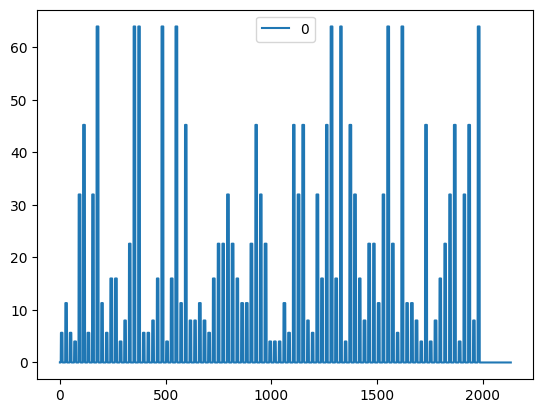

In [84]:
# not sure what this is
import seaborn as sns
sns.lineplot(record['zStuff']['exptFreq'][0][1])


In [85]:
# not sure what this is
record['zStuff']['trialDFF'][0][3].shape

(9, 10, 100, 22)

## Cell Info

In [86]:
record['CellInfo'].dtype.fields.keys()

dict_keys(['cellDists', 'cellAngles', 'sigTrial', 'sigStim', 'sigOff'])

In [87]:
# distance of each neuron to each other neuron
# what is the unit?
for plane in range(1,6):
    print(plane)
    display(pd.DataFrame(record['CellInfo']['cellDists'][0][plane]))
    break

1


,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,77
0,0.0,45.406559,61.956763,78.532831,92.821878,69.346205,102.555657,109.377833,114.663846,145.865017,...,265.110521,103.040833,135.850260,144.262810,140.076467,184.441288,225.496823,143.439961,164.513942,329.144002
1,NaN,0.000000,18.102687,33.903879,56.850380,63.459365,57.277444,63.976052,69.285061,100.750940,...,275.712681,58.006153,106.089427,109.426950,98.708795,216.618549,258.908519,184.871640,188.436146,341.111137
2,NaN,NaN,0.000000,16.620555,40.598323,61.212030,41.124345,48.563699,54.519475,86.762499,...,289.074094,45.130702,106.352341,106.249818,90.279009,234.338122,276.704331,202.848395,205.111316,354.600688
3,NaN,NaN,NaN,0.000000,34.276851,70.152413,24.716654,32.481081,38.765463,71.150784,...,296.179010,31.301626,102.085971,98.911004,78.774351,247.926282,290.446674,218.672619,216.814115,361.729569
4,NaN,NaN,NaN,NaN,0.000000,53.899598,42.919967,50.391618,56.916904,85.295980,...,329.140556,57.212661,134.748854,129.281971,104.326985,272.852680,314.924902,236.260918,245.254871,394.694056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,42.663515,74.452484,49.805473,189.740942
74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,100.858302,86.476787,182.869545
75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,99.945450,263.288912
76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,173.847864


In [88]:
# would have to recompute the euclidean distance of each pair of neurons again

In [89]:
# angle of axon to the dendrite, presumably
# this paper doesn't use the angle so I guess we could ignore it
for plane in range(1,6):
    print(plane)
    display(pd.DataFrame(record['CellInfo']['cellAngles'][0][plane]))
    break

1


,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,77
0,NaN,-160.47827,-168.407825,-167.409617,171.564232,136.363928,-163.696324,-161.113913,-158.920616,-155.075430,...,-61.704936,-154.983107,-119.134292,-126.777186,-140.296306,-30.134642,-26.874516,-8.108124,-45.191623,-58.978167
1,NaN,NaN,171.347458,-176.710757,149.574216,96.689315,-166.246929,-161.565051,-157.899867,-152.643348,...,-52.337744,-150.684114,-102.711133,-113.466076,-131.164681,-20.941464,-19.578534,-1.567703,-32.607286,-51.483071
2,NaN,NaN,NaN,-163.686148,140.053826,80.118594,-156.587886,-151.792509,-148.124637,-145.597335,...,-49.858731,-136.397182,-92.935674,-103.985360,-121.429566,-19.999360,-18.868034,-2.198374,-30.553709,-49.494161
3,NaN,NaN,NaN,NaN,116.274212,67.844553,-151.821410,-145.738897,-141.519802,-141.438050,...,-46.916241,-122.307336,-84.093859,-95.643319,-113.272905,-17.724119,-16.978590,-0.815543,-27.346726,-47.092064
4,NaN,NaN,NaN,NaN,NaN,39.434901,-98.864623,-103.392498,-105.461218,-118.318456,...,-48.642051,-91.558685,-79.014503,-87.585344,-98.794897,-22.908949,-21.525382,-8.236848,-32.101727,-48.516545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-12.642152,103.600543,-151.032339,-86.943989
74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125.897378,-170.156277,-99.923245
75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-105.118188,-83.977699
76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-72.011079


In [90]:
# is this the signals that are significant in each trial?
# there are 10 trials inside?
record['CellInfo']['sigTrial'][0][1].shape

(78, 9, 10)

In [91]:
# is this the signals that are significant for each stimulus?
# yes - should be p-value of ANOVA across baseline, P < 0.01, BUT ends up being P < 0.05 :P
pd.DataFrame(record['CellInfo']['sigStim'][0][1])

,0,1,2,3,4,5,6,7,8
0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
73,0,0,0,0,0,0,0,0,0
74,0,0,1,0,0,0,0,0,0
75,0,0,0,0,0,0,0,0,0
76,0,0,0,0,0,0,0,0,0


In [92]:
# huh???
pd.DataFrame(record['CellInfo']['sigOff'][0][1])

,0,1,2,3,4,5,6,7,8
0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,1,0,0,0
4,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
73,0,0,0,0,0,0,0,0,0
74,0,0,0,0,0,0,0,0,0
75,0,0,0,0,0,0,1,0,0
76,0,0,0,1,0,0,0,0,0


## corr and BF info

In [93]:
# BF info: the frequency that elicits the peak of the tuning curve for each neuron
# we can ignore this, wasn't used in the graph network part of paper

pd.DataFrame(record['BFinfo'][:, 1])

,cellnum,NONcellnum,BFval,BFresp,CFval,CFresp,BL,fraVals,bandwidth,normFRA,RFS,RFSBinary,sigRespCells,sigOffRespCells
0,"[[1], [9], [10], [13], [14], [18], [19], [20],...","[[2], [3], [4], [5], [6], [7], [8], [11], [12]...","[[3], [8], [4], [9], [1], [3], [3], [3], [1], ...","[[26.850229533754874], [17.192881752807928], [...","[[1.0], [nan], [nan], [nan], [nan], [nan], [na...","[[26.850229533754874], [nan], [nan], [nan], [n...","[[1], [1], [1], [1], [1], [1], [1], [1], [1], ...","[[[12.390694257695314, 15.736113856876134, 26....","[[2.38], [nan], [2.77], [nan], [nan], [nan], [...","[[0.015886584592534215, 0.24357525126579024, 1...","[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...","[[0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, ...","[[1], [9], [10], [13], [14], [18], [19], [20],...","[[4], [8], [26], [31], [34], [43], [45], [63],..."


In [94]:
# this contains information about the experiment!!
for d in record['CorrInfo'].dtype.fields.keys():
    print(d) #, ':', record['exptVars'][d])

SigCorrs
NoiseCorrsTrial
NoiseCorrsVec


In [95]:
# perhaps the signal correlation between each neuron in a plane
pd.DataFrame(record['CorrInfo']['SigCorrs'][0][1])

,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,77
0,NaN,0.053426,0.376339,0.363409,0.229670,0.327637,0.612616,0.266189,-0.322981,0.290570,...,0.346268,0.218497,0.417912,0.082978,0.065208,0.742576,0.242792,0.455971,0.777719,0.258998
1,NaN,NaN,0.237212,0.192618,0.096188,-0.027655,0.052036,0.244153,0.602687,0.187199,...,-0.266888,0.275192,-0.140691,0.688193,-0.275163,-0.331086,0.427649,-0.227791,-0.288037,-0.351927
2,NaN,NaN,NaN,0.675969,0.520021,0.070257,-0.364703,0.162196,0.157422,0.578411,...,-0.248563,-0.154037,0.264237,0.575617,0.330618,0.131755,0.306152,0.265260,0.195375,-0.314676
3,NaN,NaN,NaN,NaN,0.095609,-0.463841,-0.089438,-0.348972,-0.332689,0.753903,...,0.073309,-0.307069,0.152455,0.591024,0.234035,0.266896,0.019802,0.377084,0.366548,-0.098279
4,NaN,NaN,NaN,NaN,NaN,0.601048,-0.321368,0.320106,0.355355,0.315902,...,-0.451526,-0.298450,0.445258,0.065212,-0.044323,0.237527,0.103822,0.235560,-0.037574,0.120596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.053972,0.636224,0.747007,0.684009
74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.125675,0.285838,-0.098360
75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.647422,-0.000728
76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.195000


In [96]:
# trial-to-trial covariation between each pair of neurons in a plane
pd.DataFrame(record['CorrInfo']['NoiseCorrsVec'][0][1])

,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,77
0,NaN,-0.204916,0.261557,0.515486,0.349976,0.083993,-0.062551,0.149515,0.097088,0.124752,...,0.020060,0.137464,0.003047,0.328469,0.051147,0.030156,0.084976,0.364415,0.372816,-0.015833
1,NaN,NaN,0.031715,0.072942,0.055890,0.090363,0.264870,0.235011,0.145683,0.046933,...,0.094102,0.068201,0.147447,0.091444,0.060479,0.168448,0.181821,-0.026562,-0.004285,0.131611
2,NaN,NaN,NaN,0.315882,0.225433,-0.003172,0.071138,0.156539,0.146133,0.187610,...,-0.006675,0.212335,0.025140,0.174466,0.196362,0.110936,0.289337,0.238070,0.257124,0.040354
3,NaN,NaN,NaN,NaN,0.412357,-0.111365,0.021385,0.090291,0.294149,0.165138,...,0.000982,0.173526,0.112396,0.187953,0.184696,0.048446,0.145342,0.241624,0.394450,0.105222
4,NaN,NaN,NaN,NaN,NaN,0.138365,-0.097040,0.217451,-0.019941,-0.051424,...,-0.262913,0.112689,0.208334,0.065976,-0.047173,0.209723,0.349835,0.112709,0.242988,0.195539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.297138,0.240012,0.274624,0.049048
74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.246775,0.256724,0.222760
75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.236018,0.068906
76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.160524
